# CNN: Aplicando Técnicas de Green Deep Learning

Nesse trabalho escolhemos o dataset do CIFAKE, que contém um total de 20000 imagens, sendo 10000 que realmente fotram fotografadas e 10000 que foram geradas por um computador. O intuito é adaptar uma CNN já existente aplicando Fine Tunning em um modelo já existente, nesse caso o ResNet50, para classificar se essas imagens são genuínas (REAL) ou falsas (FAKE).

## Download do Dataset

Essa etapa só é necessária caso o dataset ainda não esteja na máquina que está rodando. Depois de rodar esse bloco precisa copiar o caminho do diretório de onde está salvo o dataset e adicioná-lo nas variáveis globais (models/globals) em DATASET_PATH.

In [8]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

# print("Path to dataset files:", path)

## Instalando dependências

In [ ]:
# pip install ipykernel
# pip3 install torch torchvision torchaudio
# pip install matplotlib
# pip install scikit-learn

## Imports

In [3]:
import torch
import torchvision
from torch import nn, optim
from torchvision import models, transforms
import os
import numpy as np

from modules import utils
from modules import globals
from modules.training_functions import train, validate
from torch.utils.data import Subset
import torch.nn.utils.prune as prune

## Visualizando e adaptando os dados

Afim de explorar o dataset exibimos 9 imagens do CIFAKE e treino e 9 de teste já transformadas para o padrão do ImageNet. Isso é feito porque ResNet50 foi treinado com esse padrão de imagem e para que ele performe bem no nosso dataset é necessário que a entrada possua as mesmas características gerais.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..1.4481792].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9406626].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7136741..1.7162529].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.64].
Cl

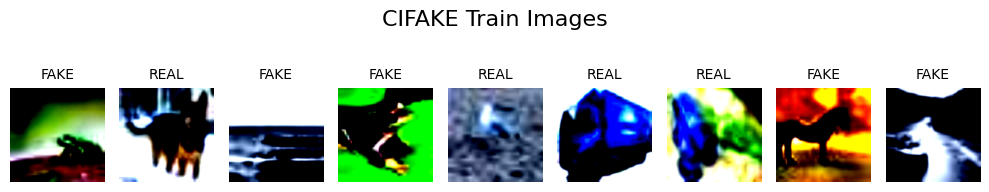

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.3060222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5778649..2.2914162].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4929972..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582842..2.3959

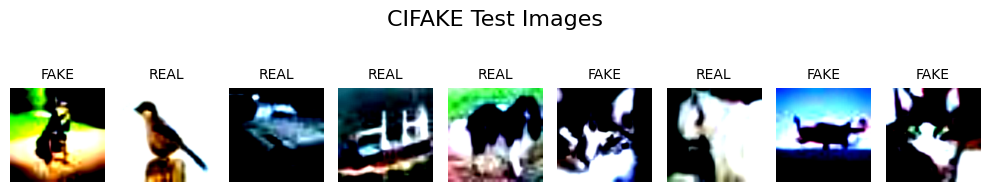

In [12]:
import random


transform = transforms.Compose([
                                     transforms.Resize(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])
                  ])


# Load the training dataset
train_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(globals.DATASET_PATH, 'train'),
    transform=transform
)

# Load the test dataset
test_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(globals.DATASET_PATH, 'test'),
    transform=transform
)

# Cria subsets para testar a lógica do modelo com um número menor do dataset (descomentar para usar)
subset_train_indices = list(range(globals.NUM_SAMPLES_TRAIN_DEBUGGER))
subset_test_indices = list(range(globals.NUM_SAMPLES_TEST_DEBUGGER))

total_train_samples = len(train_dataset)
num_train_to_select = min(globals.NUM_SAMPLES_TRAIN_DEBUGGER, total_train_samples)
subset_train_indices = random.sample(range(total_train_samples), num_train_to_select)

# Pega uma amostra aleatória de índices para o teste
total_test_samples = len(test_dataset)
num_test_to_select = min(globals.NUM_SAMPLES_TEST_DEBUGGER, total_test_samples)
subset_test_indices = random.sample(range(total_test_samples), num_test_to_select)

train_dataset_debugger = Subset(train_dataset, subset_train_indices)
test_dataset_debugger = Subset(test_dataset, subset_test_indices)

train_loader = torch.utils.data.DataLoader(
    train_dataset_debugger,
    batch_size=globals.BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_dataset_debugger,
    batch_size=globals.BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

cross_entropy_function = nn.CrossEntropyLoss().to(globals.DEVICE)

utils.plot_sample(train_loader, "Train")
utils.plot_sample(test_loader, "Test")

## Fine-Tunning: ResNet18

Como dito anteriormente será realizado um Fine-tunning a partir da rede pré treinada ResNet50. Esse modelo foi treinado com o dataset do ImageNet e obteve ótimos resultados.

A principal inovação do ResNet é a utilização de conexões residuais. Dessa forma os problemas do "vanishing" ou "exploding" gradient são mitigados e possibilita um aprendizado mais rico, capaz de observar padrões complexos.

Para esse projeto é importante que a rede seja robusta, uma vez que a verficação de deepfakes não é uma tarefa simples. Por isso escolhemos a ResNet com 18 camadas ocultas.

In [ ]:
model = models.resnet18(pretrained=True).to('cpu')
print(model)

c:\Users\masar\Documents\UFF\IAVerde\ia_verde_cnn\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\masar\Documents\UFF\IAVerde\ia_verde_cnn\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Identificando e adaptando a camada fully connected (fc)

In [ ]:
print(list(model.named_children())[-1])

('fc', Linear(in_features=512, out_features=1000, bias=True))


Precisamos substituir a fc do modelo, uma vez que a mesma possui uma classificação dos dados de entrada em 1000 classes. No caso do nosso problema, serão apenas duas: REAL e FAKE 

In [ ]:
in_features = model.fc.in_features
print(f"Features: {in_features}")

num_classes_cifake = len(globals.CLASS_NAMES)

model.fc = nn.Linear(in_features, num_classes_cifake).to('cpu')

print(f"Nova camada FC: {model.fc}")

Features: 512
Nova camada FC: Linear(in_features=512, out_features=2, bias=True)


#### Fase 1: Treinamento apenas da camada fully connected

In [ ]:
# Congelar todos os parâmetros do modelo
for param in model.parameters():
    param.requires_grad = False

# Descongelar APENAS os parâmetros da nova camada 'fc'
for param in model.fc.parameters():
    param.requires_grad = True

# Otimizador para a Fase 1: Ele verá apenas os parâmetros que requires_grad=True
optimizer_phase1 = optim.Adam(model.fc.parameters(),
                              lr=globals.LEARNING_RATE_CLASSIFIER, # Usando a taxa de aprendizado para o classificador
                              weight_decay=globals.WEIGHT_DECAY)

for epoch in range(globals.EPOCHS_FIRST_PHASE):
    print(f'\n ----------- Época [{epoch}] -----------')
    train(train_loader, model, optimizer_phase1, cross_entropy_function)
    validate(test_loader, model, cross_entropy_function)


 ----------- Época [0] -----------
250/250
Treino
Loss: 0.4686 +/- 0.1517, Acc: 77.53, Time: 271.36
63/63
Validação
Loss: 0.3309 +/- 0.1284, Acc: 85.80, Time: 67.63



#### Fase 2: Treinamento de todas as camadas

In [ ]:
# Descongelar todos os parâmetros do modelo
for param in model.parameters():
    param.requires_grad = True

optimizer_phase2 = optim.Adam([
    # Geralmente uma LR um pouco menor que na Fase 1, mas maior que as features
    {'params': model.fc.parameters(), 'lr': globals.LEARNING_RATE_CLASSIFIER, 'weight_decay': globals.WEIGHT_DECAY},
    # Grupo 2: Parâmetros das camadas convolucionais (features)
    # LR muito baixa para ajustes sutis
    {'params': [p for name, p in model.named_parameters() if 'fc' not in name],
     'lr': globals.LEARNING_RATE_FEATURES, 'weight_decay': globals.WEIGHT_DECAY}
]) 

for epoch in range(globals.EPOCHS_SECOND_PHASE):
    print(f'\n----------- Época [{epoch + globals.EPOCHS_FIRST_PHASE}] -----------')
    # O número da época é ajustado para continuar da onde parou na fase anterior
    train(train_loader, model, optimizer_phase2, cross_entropy_function)
    validate(test_loader, model, cross_entropy_function)


----------- Época [1] -----------
250/250
Treino
Loss: 0.3155 +/- 0.1921, Acc: 87.30, Time: 640.01
63/63
Validação
Loss: 0.1989 +/- 0.1313, Acc: 90.40, Time: 55.70



### Salvando o Modelo

In [ ]:
model_path_float32 = "resnet18_cifake_finetuned_float32.pth"
torch.save(model.state_dict(), model_path_float32)
print(f"\nModelo original salvo em: {model_path_float32}")


Modelo original salvo em: resnet50_cifake_finetuned_float32.pth


## Estratégia escolhida: Prunning

### Carregando modelo pré-treinado anteriormente

In [52]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) 

device = torch.device(globals.DEVICE)
model.to(device)

# --- 2. Carregar os pesos salvos ---
model_path_float32 = "resnet18_cifake_finetuned_float32.pth"

try:
    model.load_state_dict(torch.load(model_path_float32, map_location=device))
    print(f"Modelo '{model_path_float32}' carregado com sucesso!")
except FileNotFoundError:
    print(f"Erro: O arquivo '{model_path_float32}' não foi encontrado. Verifique o caminho.")
except Exception as e:
    print(f"Erro ao carregar o modelo: {e}")

model.eval()
print("Modelo configurado para modo de avaliação.")


Modelo 'resnet18_cifake_finetuned_float32.pth' carregado com sucesso!
Modelo configurado para modo de avaliação.


In [71]:
# --- 2. Aplicar a Poda (Pruning) ---
print("\n--- Aplicando Pruning ---")

pruning_model = model

# Poda na camada Fully Connected (fc)
pruning_amount = 0.5 # Podar 50% dos pesos
pruning_targets = [
    (pruning_model.fc, 'weight'),
    (pruning_model.layer1[0].conv2, 'weight'), # Exemplo: 1º bloco do layer1, conv2
    (pruning_model.layer1[1].conv2, 'weight'), # Exemplo: 2º bloco do layer1, conv2
    (pruning_model.layer2[0].conv2, 'weight'), # Exemplo: 1º bloco do layer2, conv2
    (pruning_model.layer2[1].conv2, 'weight'), # Exemplo: 2º bloco do layer2, conv2
    (pruning_model.layer3[0].conv2, 'weight'), # Exemplo: 1º bloco do layer3, conv2
    (pruning_model.layer3[1].conv2, 'weight'), # Exemplo: 2º bloco do layer3, conv2
    (pruning_model.layer4[0].conv2, 'weight'), # Exemplo: 1º bloco do layer4, conv2
    (pruning_model.layer4[1].conv2, 'weight'), # Exemplo: 2º bloco do layer4, conv2
]

for module, name in pruning_targets:
    prune.l1_unstructured(module, name=name, amount=pruning_amount)
    print(f"Podado {pruning_amount*100}% dos pesos da camada '{name}' em {module}.")

# Inspecionar (opcional): veja as máscaras de poda
print("\nExemplo de pesos e máscara após poda (fc):")
print(pruning_model.fc.weight)
print(pruning_model.fc.weight_mask)

# 3. Remover Permanentemente os Pesos (essencial para o tamanho do modelo)
print("\n--- Removendo permanentemente os pesos podados ---")
for module, name in pruning_targets:
    prune.remove(module, name)
    print(f"Pesos removidos permanentemente para {name} em {module}.")


--- Aplicando Pruning ---
Podado 50.0% dos pesos da camada 'weight' em Linear(in_features=512, out_features=2, bias=True).
Podado 50.0% dos pesos da camada 'weight' em Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False).
Podado 50.0% dos pesos da camada 'weight' em Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False).
Podado 50.0% dos pesos da camada 'weight' em Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False).
Podado 50.0% dos pesos da camada 'weight' em Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False).
Podado 50.0% dos pesos da camada 'weight' em Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False).
Podado 50.0% dos pesos da camada 'weight' em Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False).
Podado 50.0% dos pesos da camada 'weight' em Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [62]:
model_path_pruned = "resnet18_cifake_pruned.pth"
torch.save(pruning_model.state_dict(), model_path_pruned)
print(f"\nModelo podado salvo em: {model_path_pruned}")


Modelo podado salvo em: resnet18_cifake_pruned.pth


In [63]:
# --- 4. Avaliar o Modelo Podado ---
print("\n--- Avaliando o Modelo Podado ---")
acc_pruned, prec_pruned, rec_pruned, f1_pruned, cm_pruned, loss_pruned = validate(test_loader, pruning_model, cross_entropy_function)
print(f"Acurácia (Podado): {acc_pruned:.4f}")
print(f"Precisão (Podado): {prec_pruned:.4f}")
print(f"Recall (Podado): {rec_pruned:.4f}")
print(f"F1-Score (Podado): {f1_pruned:.4f}")
print(f"Matriz de Confusão (Podado):\n{cm_pruned}")



--- Avaliando o Modelo Podado ---
63/63
Validação
Loss: 0.3360 +/- 0.1126, Acc: 84.00, Time: 50.24

Acurácia (Podado): 0.8400
Precisão (Podado): 0.7557
Recall (Podado): 0.9789
F1-Score (Podado): 0.8529
Matriz de Confusão (Podado):
[[376 150]
 [ 10 464]]


In [64]:
import time
import sys
import torch
import torchvision.models as models
from torch import nn

# --- Funções Auxiliares para Medição ---

def measure_inference_time(model, dummy_input, num_warmup=10, num_runs=100):
    model.eval()
    
    dummy_input = dummy_input.to(next(model.parameters()).device)

    with torch.no_grad():
        for _ in range(num_warmup):
            _ = model(dummy_input)

    timings = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_time = time.perf_counter()
            _ = model(dummy_input)
            end_time = time.perf_counter()
            timings.append(end_time - start_time)

    mean_time_ms = (sum(timings) / num_runs) * 1000
    return mean_time_ms

def measure_model_memory_usage(model):
    mem_bytes = sum(p.element_size() * p.nelement() for p in model.parameters())
    mem_mb = mem_bytes / (1024 * 1024)
    return mem_mb

# --- Carregar Modelos para Comparação ---

# Re-carregue o modelo original (float32) para ter uma base de comparação limpa
# Certifique-se de que a arquitetura corresponde ao modelo original salvo!
# No seu código, você usa resnet18 para a poda, mas menciona resnet50 para o original.
# Vou usar resnet18 para consistência com o código de poda que você mostrou.

# Modelo Original (Float32)
original_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs_original = original_model.fc.in_features
original_model.fc = nn.Linear(num_ftrs_original, 2)
original_model_path = "resnet18_cifake_finetuned_float32.pth" # Verifique se este é o nome correto
try:
    original_model.load_state_dict(torch.load(original_model_path, map_location='cpu'))
    original_model.to('cpu') # Mova para CPU para medição consistente
    original_model.eval()
    print(f"\nModelo original '{original_model_path}' carregado para avaliação de desempenho.")
except FileNotFoundError:
    print(f"ERRO: Modelo original '{original_model_path}' não encontrado. Não será possível comparar.")
    original_model = None # Para evitar erros se o arquivo não existir

# Modelo Podado
print("Modelo podado pronto para avaliação de desempenho.")

# --- Configurar Input de Teste ---
dummy_input_inference = torch.randn(1, 3, 224, 224) # Um único input para medir a latência

# --- Realizar as Medições e Imprimir Resultados ---
print("\n--- Resultados de Eficiência do Modelo ---")

if original_model:
    # Medição do Modelo Original
    time_original = measure_inference_time(model, dummy_input_inference)
    mem_original = measure_model_memory_usage(model)
    print(f"\nModelo Original (Float32):")
    print(f"  Tamanho (parâmetros em memória): {mem_original:.2f} MB")
    print(f"  Tempo médio de inferência (1 imagem): {time_original:.3f} ms")

# Medição do Modelo Podado
time_pruned = measure_inference_time(pruning_model, dummy_input_inference)
mem_pruned = measure_model_memory_usage(pruning_model)
print(f"\nModelo Podado (Float32):")
print(f"  Tamanho (parâmetros em memória): {mem_pruned:.2f} MB")
print(f"  Tempo médio de inferência (1 imagem): {time_pruned:.3f} ms")

if original_model:
    time_reduction_pruned = ((time_original - time_pruned) / time_original) * 100
    mem_reduction_pruned = ((mem_original - mem_pruned) / mem_original) * 100
    print(f"  Redução no tempo de inferência (Podado vs Original): {time_reduction_pruned:.2f}%")
    print(f"  Redução no uso de memória (Podado vs Original): {mem_reduction_pruned:.2f}%") 



Modelo original 'resnet18_cifake_finetuned_float32.pth' carregado para avaliação de desempenho.
Modelo podado pronto para avaliação de desempenho.

--- Resultados de Eficiência do Modelo ---

Modelo Original (Float32):
  Tamanho (parâmetros em memória): 42.64 MB
  Tempo médio de inferência (1 imagem): 70.034 ms

Modelo Podado (Float32):
  Tamanho (parâmetros em memória): 42.64 MB
  Tempo médio de inferência (1 imagem): 68.221 ms
  Redução no tempo de inferência (Podado vs Original): 2.59%
  Redução no uso de memória (Podado vs Original): 0.00%
